# Benchmarks
In this section, the different solver options of the solve_ivp() function will be compared in terms of run-time performance.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib

import time
import pandas as pd
import one_d_problem_physics as opp


In [2]:
plt.rcParams["figure.figsize"] = (8,6)
font = {'size'   : 14}
matplotlib.rc('font', **font)

# Benchmark script
The script below will return a dictionary containing the run times in seconds for the specified integration-methods and for the vectorized and un-vectorized version of the method. The resolutions will be 20, 40, 80, 160 and 320. Another item in the dictionary will be the list of resolutions, which is used as the horizontal axis for plotting.
Since these benchmarks are quite time consuming, the example below uses a reduced list of resolutions for convenience reasons.

Setting up the dictionary in this manner is very convenient, because it can easily be turned into a `pandas.DataFrame()` object, which is convenient both for saving the results to a .csv file or plotting the results.

In [3]:
def benchmark_script(methods=['RK45', 'Radau']):
    print('########## BENCHMARK SCRIPT #############')
    # ress = [20, 40, 80, 160, 320] # original list of resolutions (reduced below)
    ress = [20, 40, 80]
    vectorized = [True, False]
    mat = 'AAC_A4_mod'

    results = {'resolution': ress}
    for m in methods:
        for v in vectorized:
            timings = []
            for r in ress:
                my_problem = opp.one_d_problem(res=r, sim_time=24, material=mat, length=.1)
                my_problem.fluid_flow_west = True
                my_problem.fluid_flow_east = False
                my_problem.vapour_flow_west = False
                my_problem.vapour_flow_east = False

                my_problem.liquid_conduction = True
                my_problem.vapour_diffusion = True
                
                w0 = my_problem.w[:]
                t0 = 0  # Start time in hours
                tf = my_problem.sim_time  # End time in hours
                t_eval = np.linspace(t0, tf, 100)

                print(f'Calling scipy.integrate.sloveivp() ... resolution: {r}, vectorized: {v}, method: {m}, material: {mat}')
                start_time = time.time()
                sol = solve_ivp(my_problem.dwdt_calc, (t0, tf), w0, t_eval=t_eval, method=m, vectorized=v, dense_output=False, atol=1e-7,
                                rtol=1e-5)
                del sol
                t = time.time() - start_time
                print(f'time elapsed: {t:.3f} s')
                timings.append(t)

            key = m + '_' + mat + '_v' + str(v)
            results[key] = timings
    return results


In [4]:
d = benchmark_script()

########## BENCHMARK SCRIPT #############
Calling scipy.integrate.sloveivp() ... resolution: 20, vectorized: True, method: RK45, material: AAC_A4_mod


G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:22: RuntimeWarning: overflow encountered in exp
  rh = np.exp(-p_suc / (rho_w * Rv * T_ref))
G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:180: RuntimeWarning: divide by zero encountered in true_divide
  dwdp_suc = (-1) * self.free_saturation * self.pore_size / (1 + self.pore_size * p_suc)**2
G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:176: RuntimeWarning: divide by zero encountered in true_divide
  return self.free_saturation / (1. + self.pore_size * P_suc)
G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:223: RuntimeWarning: invalid value encountered in subtract
  dwdt[P] += 1/ self.dx**2 * ( (K_W + K_E) * p_suc[P] - K_W*p_suc[W] - K_E*p_suc[E]) * self.liquid_conduction


time elapsed: 1.360 s
Calling scipy.integrate.sloveivp() ... resolution: 40, vectorized: True, method: RK45, material: AAC_A4_mod
time elapsed: 5.448 s
Calling scipy.integrate.sloveivp() ... resolution: 80, vectorized: True, method: RK45, material: AAC_A4_mod
time elapsed: 27.026 s
Calling scipy.integrate.sloveivp() ... resolution: 20, vectorized: False, method: RK45, material: AAC_A4_mod
time elapsed: 1.191 s
Calling scipy.integrate.sloveivp() ... resolution: 40, vectorized: False, method: RK45, material: AAC_A4_mod
time elapsed: 4.807 s
Calling scipy.integrate.sloveivp() ... resolution: 80, vectorized: False, method: RK45, material: AAC_A4_mod
time elapsed: 24.286 s
Calling scipy.integrate.sloveivp() ... resolution: 20, vectorized: True, method: Radau, material: AAC_A4_mod
time elapsed: 1.020 s
Calling scipy.integrate.sloveivp() ... resolution: 40, vectorized: True, method: Radau, material: AAC_A4_mod


G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:250: RuntimeWarning: invalid value encountered in multiply
  dwdt[-2] += self.delta_p / self.dx**2 * (p_vap[-1] - p_vap[-2]) * self.vapour_flow_east * self.vapour_diffusion


time elapsed: 1.857 s
Calling scipy.integrate.sloveivp() ... resolution: 80, vectorized: True, method: Radau, material: AAC_A4_mod
time elapsed: 4.394 s
Calling scipy.integrate.sloveivp() ... resolution: 20, vectorized: False, method: Radau, material: AAC_A4_mod
time elapsed: 1.281 s
Calling scipy.integrate.sloveivp() ... resolution: 40, vectorized: False, method: Radau, material: AAC_A4_mod
time elapsed: 2.906 s
Calling scipy.integrate.sloveivp() ... resolution: 80, vectorized: False, method: Radau, material: AAC_A4_mod
time elapsed: 9.661 s


# Plotting
The functions below plot the results either from a dictionary or a pre-saved .csv file

In [16]:
def plot_benchmark_file(filename):
    df = pd.read_csv(filename, sep=';')
    df['linear-to-resolution-indicator'] = df['resolution'] * 0.02 # multiplicative constant for vertical shifting in logarithmic plot
    df['squared-resolution-indicator'] = df['resolution']**2 * 0.002 # multiplicative constant for vertical shifting in logarithmic plot
    df.set_index('resolution', inplace=True)
    df.plot(loglog=True, use_index=True, style=['-','-','-','-','--','--'])
    plt.ylabel('run time in s')
    plt.grid()
    plt.show()

def plot_benchmark_dict(d):
    df = pd.DataFrame(d)
    df.set_index('resolution', inplace=True)
    df.plot(loglog=True, use_index=True)
    plt.ylabel('run time in s')
    plt.grid()
    plt.show()

# Results and interpretation
Here, the results loaded from pre-calculated benchmark files are shown:

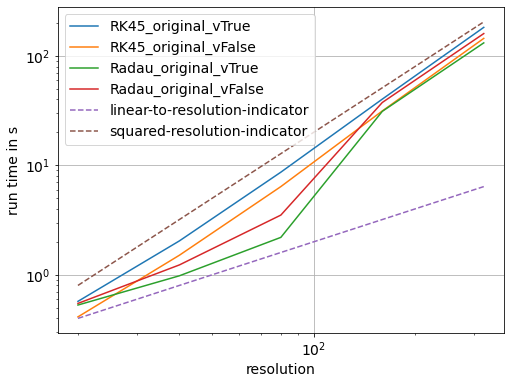

In [17]:
plot_benchmark_file('./benchmarks/benchmarks_RK_Radau.csv')

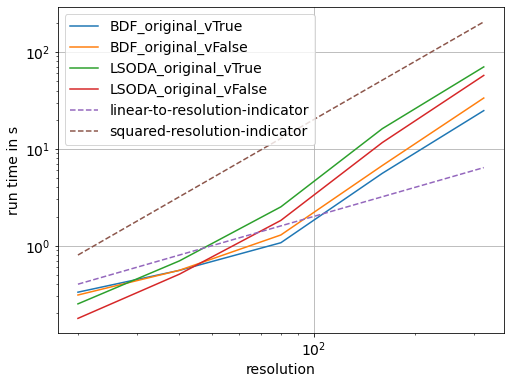

In [18]:
plot_benchmark_file('./benchmarks/benchmarks_BDF_LSODA.csv')

The **results generally show** that the run time increases proportionally with the square of the resolution, since the slopes of the curves are parallel to the corresponding indicator-curve. This suggests, that the solvers end up increasing the number of time steps proportionally with increasing resolution in order to achieve the desired accuracy (specified with `atol` and `rtol`).

$$
total \;number \;of \;timesteps = resolution \cdot number \;of \;timesteps \;per \;cell = resolution \cdot (resolution \cdot some \; constant)
$$

This effect can only be observed above a resolution of 80 cells. Up to this resolution some solvers a show linear increase in run time. It seems, that they are able to keep the number of timesteps independent from the number of cells if the  resolution is small enough. 

When **comparing the solvers**, it is noticable, that `BDF` seems to be the fastest solver with the vectorized version being a little faster than the non-vectorized one. `LSODA` is faster than `Radau` and the good old `RK45` is slowest, with the vectorized version actually being even slower, than the non-vectorized one.  